In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization
import wandb
from wandb.keras import WandbCallback

print(tf.__version__)

2.10.0


In [2]:
tf.config.run_functions_eagerly(True)

In [3]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

data_news_headlines = pd.read_json("../shared_data/x1.json")

# Adjust news headline data
data_news_headlines = data_news_headlines.drop(columns='article_link', axis=1)
data_news_headlines = data_news_headlines.rename(columns ={'headline':'text', 'is_sarcastic':'label'})
data_news_headlines = data_news_headlines.reindex(columns=['text','label'])
data_news_headlines.head()

In [4]:
data_tweets = pd.read_csv("../../shared_data/dataset_csv.csv")

# Adjust tweets data
data_tweets = data_tweets.rename(columns={'tweets':'text'})
data_tweets.head()

,text,label
0,I love working midnights tweet,1
1,I hate when I buy a bag of air and there's chi...,1
2,my grandad always sounds so ill when i speak t...,0
3,"I realize I'm annoying to everyone, so I won't...",0
4,I love when I find these dudes on vine!! #Foll...,1


In [5]:
data_sitcoms = pd.read_csv("../../shared_data/mustard++_text.csv")

# Adjust sitcom data
data_sitcoms = data_sitcoms.drop(columns=['SCENE','KEY','END_TIME','SPEAKER','SHOW','Sarcasm_Type','Implicit_Emotion','Explicit_Emotion','Valence','Arousal'], axis=1)
data_sitcoms = data_sitcoms.rename(columns={'SENTENCE':'text','Sarcasm':'label'})

# remove empty label rows
for index, row in data_sitcoms.iterrows():
    if math.isnan(row['label']):
        data_sitcoms = data_sitcoms.drop(index, axis='index')

data_sitcoms.head()

,text,label
5,"And of those few months, how long have you bee...",0.0
14,"Let the dead man talk. So, why do you think that?",0.0
18,"What else? Sell it on eBay as ""slightly used.""",0.0
24,"Good idea, sit with her. Hold her, comfort her...",1.0
31,"Well, now that I've given up string theory, I'...",0.0


data_reddit = pd.read_csv("../shared_data/train-balanced-sarcasm.csv")

# Adjust reddit data
data_reddit = data_reddit.drop(columns=['author','subreddit','score','ups','downs','date','created_utc','parent_comment'], axis=1)
data_reddit = data_reddit.rename(columns={'comment':'text'})
data_reddit = data_reddit.reindex(columns=['text','label'])

data_reddit.head()

In [6]:
# Combine all 4 datasets
#data = pd.concat([data_news_headlines,data_tweets,data_sitcoms,data_reddit], ignore_index=True)
# Combine 3 datasets
data = pd.concat([data_tweets,data_sitcoms], ignore_index=True)

# remove non string (nan) rows
for index, row in data.iterrows():
    if not type(row['text']) == str:
        data = data.drop(index, axis='index')

# Shuffle the rows
data = data.sample(frac=1).reset_index(drop=True)

data.head()

,text,label
0,Whoa! Walking up to a strange woman in a bar u...,0.0
1,I love shoveling out tons of money for new tir...,1.0
2,Everything's just great!!!???????? ?????????,1.0
3,I always love emergency doctor appointments. ...,1.0
4,"Well ah, I've been doing a lot of thinking, an...",0.0


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3196 entries, 0 to 3195
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   text    3196 non-null   object 
 1   label   3196 non-null   float64
dtypes: float64(1), object(1)
memory usage: 50.1+ KB


Set dataset and training variables

In [8]:
subset_size = len(data.index) ##was 1400
testing_size = int(subset_size * 0.4)
validation_size = int(subset_size * 0.2)
shuffle_size = subset_size - validation_size

data_batch_size = 4 ##was32

In [9]:
data = data.sample(frac=1).reset_index(drop=True) ##was just data
train_data = data.head(subset_size) ##was just data
test_data = data.tail(testing_size) ##was just data

In [10]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][validation_size:], 
        train_data['label'][validation_size:]
    )
).shuffle(shuffle_size).batch(data_batch_size)

val_ds = tf.data.Dataset.from_tensor_slices(
    (
        train_data['text'][:validation_size],
        train_data['label'][:validation_size]
    )
).batch(data_batch_size)

test_ds = tf.data.Dataset.from_tensor_slices(
    (
        test_data['text'],
        test_data['label']
    )
)

Set training variables

In [11]:
epochs = 3
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)
init_lr = 3e-5

## Download Preprocessing and Encoding Model Layers from TensorflowHub
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1 original model from Nathan
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/2 smaller model, less accurate
## https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/2 more layers, smallest hidden layers, less accurate

In [12]:
preprocessing_layer = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3', 
    name='preprocessing'
)

bert_encoder = hub.KerasLayer(
    'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/4', 
    trainable=True, 
    name='BERT_encoder'
)

Create the model using, the BERT encoder

In [13]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    encoder_inputs = preprocessing_layer(text_input)
    outputs = bert_encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.5)(net) # was 0.1
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [14]:
wandb.init(project="sarcasmscanner", entity="nrtyc4")

#define the parameters for tokenizing and padding
vocab_size = 5000
embedding_dim = 32
max_length = 500

### Initialize and config the Weights and Biases graphing library
w_config = {
    "epochs": epochs,
    "vocab_size": vocab_size,
    "embedding_dim": embedding_dim,
    "max_sentence_word_length": max_length,
    "batch_size": data_batch_size,
    "subset_size": subset_size,
    "training_size": subset_size - testing_size - validation_size,
    "testing_size": testing_size,
    "validation_size": validation_size,
    "dataset": "sitcoms+tweets",
    "architecture": "BERT"
}

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: nrtyc4. Use `wandb login --relogin` to force relogin


Sanity check of model (untrained result)

In [15]:

text_test = ["Please, keep talking. I always yawn when I am interested."]
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.71855384]], shape=(1, 1), dtype=float32)


In [16]:
tf.keras.utils.plot_model(classifier_model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Set loss function

In [17]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

Create the optimizer

In [18]:
optimizer = optimization.create_optimizer(
    init_lr=init_lr,
    num_train_steps=num_train_steps,
    num_warmup_steps=num_warmup_steps,
    optimizer_type='adamw'
)

Compile the model

In [19]:
# classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
classifier_model.compile(loss=loss,optimizer=optimizer,metrics=metrics)
classifier_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 preprocessing (KerasLayer)     {'input_word_ids':   0           ['text[0][0]']                   
                                (None, 128),                                                      
                                 'input_mask': (Non                                               
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128)}                                                  

Train the model

In [20]:
history = classifier_model.fit(x=train_ds,
                        validation_data=val_ds,
                        epochs=epochs,
                        callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/3
640/640 [==============================] - ETA: 0s - loss: 0.6141 - binary_accuracy: 0.7149

INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\BERT Models\wandb\run-20221021_182017-1k0ascvp\files\model-best\assets


INFO:tensorflow:Assets written to: c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\BERT Models\wandb\run-20221021_182017-1k0ascvp\files\model-best\assets
wandb: Adding directory to artifact (c:\Users\natth\Desktop\School Work\Github School Code\ScannerTraining\Thompson\BERT Models\wandb\run-20221021_182017-1k0ascvp\files\model-best)... Done. 22.9s


640/640 [==============================] - 320s 484ms/step - loss: 0.6141 - binary_accuracy: 0.7149 - val_loss: 0.4733 - val_binary_accuracy: 0.8200
Epoch 2/3
640/640 [==============================] - 223s 349ms/step - loss: 0.4863 - binary_accuracy: 0.8670 - val_loss: 0.6427 - val_binary_accuracy: 0.8138
Epoch 3/3
640/640 [==============================] - 222s 348ms/step - loss: 0.2911 - binary_accuracy: 0.9390 - val_loss: 0.8438 - val_binary_accuracy: 0.8153


Test the model

In [21]:
loss, accuracy = classifier_model.evaluate(test_ds.batch(data_batch_size))

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

320/320 [==============================] - 28s 89ms/step - loss: 0.1626 - binary_accuracy: 0.9640
Loss: 0.16258195042610168
Accuracy: 0.964006245136261


Plot the accuracy and loss over time

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


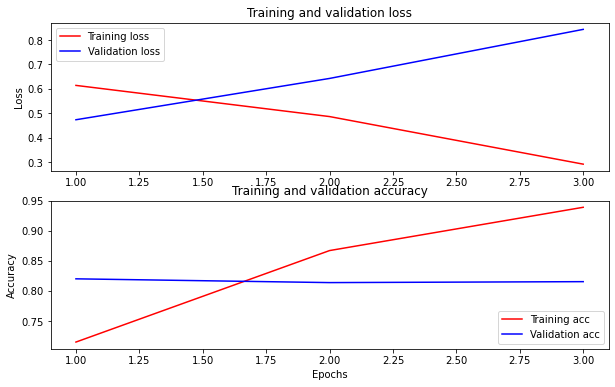

In [22]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

Export for inference

In [23]:
saved_model_path = './model_saves/bert_v4/'
classifier_model.save(saved_model_path, include_optimizer=False)

INFO:tensorflow:Assets written to: ./model_saves/bert_v4/assets


INFO:tensorflow:Assets written to: ./model_saves/bert_v4/assets


Reload and test inference

In [24]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [25]:
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

def print_my_examples(inputs, results):
  for i in range(len(inputs)):
    print('input: ', inputs[i], ' : score: ', results.numpy()[i][0], ' : rounded: ', round(results.numpy()[i][0]))
  print()


examples = [
    "Please, keep talking. I always yawn when I am interested.", # expect 1
    "Well, what a surprise.", # expect 1
    "Really, Sherlock? No! You are clever.", # expect 1
    "The quick brown fox jumps over the lazy dog", # expect 0
    "Numerous references to the phrase have occurred in movies, television, and books." # expect 0
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.9850583  : rounded:  1
input:  Well, what a surprise.  : score:  0.951293  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.32842582  : rounded:  0
input:  The quick brown fox jumps over the lazy dog  : score:  0.99717367  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.95919895  : rounded:  1

Results from the model in memory:
input:  Please, keep talking. I always yawn when I am interested.  : score:  0.9850583  : rounded:  1
input:  Well, what a surprise.  : score:  0.951293  : rounded:  1
input:  Really, Sherlock? No! You are clever.  : score:  0.32842582  : rounded:  0
input:  The quick brown fox jumps over the lazy dog  : score:  0.99717367  : rounded:  1
input:  Numerous references to the phrase have occurred in movies, television, and books.  : score:  0.95919895  : rounded:  1

